In [54]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_20.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_20.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

In [55]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [56]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [57]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [58]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [59]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


In [60]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 154/154 [00:36<00:00,  4.20it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 153/153 [00:52<00:00,  2.94it/s]


In [61]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epochs:   1%|          | 19/2500 [00:00<00:57, 43.39it/s]

Epoch 10/2500, Loss: 1.6958
Test Accuracy at Epoch 10: 69.92%
Test F1-score at Epoch 10: 0.7613
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.92      0.44      0.59       123
non_infringement       0.63      0.96      0.76       123

        accuracy                           0.70       246
       macro avg       0.77      0.70      0.68       246
    weighted avg       0.77      0.70      0.68       246

New best model saved with F1-score 0.7613 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.92      0.44      0.59       123
non_infringement       0.63      0.96      0.76       123

        accuracy                           0.70       246
       macro avg       0.77      0.70      0.68       246
    weighted avg       0.77      0.70      0.68       246

Epoch 20/2500, Loss: 0.5005


Training Epochs:   1%|          | 25/2500 [00:00<00:53, 46.58it/s]

Test Accuracy at Epoch 20: 72.36%
Test F1-score at Epoch 20: 0.7687
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.87      0.53      0.66       123
non_infringement       0.66      0.92      0.77       123

        accuracy                           0.72       246
       macro avg       0.76      0.72      0.71       246
    weighted avg       0.76      0.72      0.71       246

New best model saved with F1-score 0.7687 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.87      0.53      0.66       123
non_infringement       0.66      0.92      0.77       123

        accuracy                           0.72       246
       macro avg       0.76      0.72      0.71       246
    weighted avg       0.76      0.72      0.71       246



Training Epochs:   1%|▏         | 37/2500 [00:00<00:52, 46.75it/s]

Epoch 30/2500, Loss: 0.4248
Test Accuracy at Epoch 30: 73.98%
Test F1-score at Epoch 30: 0.7143
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.70      0.83      0.76       123
non_infringement       0.79      0.65      0.71       123

        accuracy                           0.74       246
       macro avg       0.75      0.74      0.74       246
    weighted avg       0.75      0.74      0.74       246

Epoch 40/2500, Loss: 0.3219
Test Accuracy at Epoch 40: 79.27%
Test F1-score at Epoch 40: 0.7968
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       123
non_infringement       0.78      0.81      0.80       123

        accuracy                           0.79       246
       macro avg       0.79      0.79      0.79       246
    weighted avg       0.79      0.79      0.79       246



Training Epochs:   2%|▏         | 47/2500 [00:01<00:58, 41.66it/s]

New best model saved with F1-score 0.7968 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.77      0.79       123
non_infringement       0.78      0.81      0.80       123

        accuracy                           0.79       246
       macro avg       0.79      0.79      0.79       246
    weighted avg       0.79      0.79      0.79       246



Training Epochs:   2%|▏         | 59/2500 [00:01<00:50, 48.65it/s]

Epoch 50/2500, Loss: 0.2814
Test Accuracy at Epoch 50: 80.49%
Test F1-score at Epoch 50: 0.8017
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.82      0.81       123
non_infringement       0.82      0.79      0.80       123

        accuracy                           0.80       246
       macro avg       0.81      0.80      0.80       246
    weighted avg       0.81      0.80      0.80       246

New best model saved with F1-score 0.8017 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.82      0.81       123
non_infringement       0.82      0.79      0.80       123

        accuracy                           0.80       246
       macro avg       0.81      0.80      0.80       246
    weighted avg       0.81      0.80      0.80       246

Epoch 60/2500, Loss: 0.2419
Test Accuracy at Epoch 60: 77.24%
Test F1-sco

Training Epochs:   3%|▎         | 77/2500 [00:01<00:47, 51.14it/s]

Epoch 70/2500, Loss: 0.2086
Test Accuracy at Epoch 70: 76.02%
Test F1-score at Epoch 70: 0.7468
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.74      0.81      0.77       123
non_infringement       0.79      0.71      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246

Epoch 80/2500, Loss: 0.1791
Test Accuracy at Epoch 80: 74.80%
Test F1-score at Epoch 80: 0.7304
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.72      0.81      0.76       123
non_infringement       0.79      0.68      0.73       123

        accuracy                           0.75       246
       macro avg       0.75      0.75      0.75       246
    weighted avg       0.75      0.75      0.75       246



Training Epochs:   4%|▍         | 101/2500 [00:02<00:45, 52.23it/s]

Epoch 90/2500, Loss: 0.1576
Test Accuracy at Epoch 90: 73.17%
Test F1-score at Epoch 90: 0.7080
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.70      0.81      0.75       123
non_infringement       0.78      0.65      0.71       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.73       246
    weighted avg       0.74      0.73      0.73       246

Epoch 100/2500, Loss: 0.1407
Test Accuracy at Epoch 100: 73.58%
Test F1-score at Epoch 100: 0.7059
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.70      0.84      0.76       123
non_infringement       0.80      0.63      0.71       123

        accuracy                           0.74       246
       macro avg       0.75      0.74      0.73       246
    weighted avg       0.75      0.74      0.73       246



Training Epochs:   5%|▍         | 120/2500 [00:02<00:47, 50.57it/s]

Epoch 110/2500, Loss: 0.1271
Test Accuracy at Epoch 110: 72.76%
Test F1-score at Epoch 110: 0.7022
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.69      0.81      0.75       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 120/2500, Loss: 0.1173
Test Accuracy at Epoch 120: 71.14%
Test F1-score at Epoch 120: 0.6816
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:   6%|▌         | 138/2500 [00:02<00:46, 50.82it/s]

Epoch 130/2500, Loss: 0.1085
Test Accuracy at Epoch 130: 71.54%
Test F1-score at Epoch 130: 0.6875
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 140/2500, Loss: 0.0983


Training Epochs:   6%|▌         | 150/2500 [00:03<00:48, 48.24it/s]

Test Accuracy at Epoch 140: 70.33%
Test F1-score at Epoch 140: 0.6667
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.67      0.81      0.73       123
non_infringement       0.76      0.59      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 150/2500, Loss: 0.0914
Test Accuracy at Epoch 150: 69.92%
Test F1-score at Epoch 150: 0.6542
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.66      0.83      0.73       123
non_infringement       0.77      0.57      0.65       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246



Training Epochs:   6%|▋         | 162/2500 [00:03<00:52, 44.93it/s]

Epoch 160/2500, Loss: 0.0848
Test Accuracy at Epoch 160: 68.70%
Test F1-score at Epoch 160: 0.6547
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.66      0.78      0.71       123
non_infringement       0.73      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.69      0.69      0.68       246
    weighted avg       0.69      0.69      0.68       246



Training Epochs:   7%|▋         | 175/2500 [00:03<00:46, 50.02it/s]

Epoch 170/2500, Loss: 0.0791
Test Accuracy at Epoch 170: 68.29%
Test F1-score at Epoch 170: 0.6422
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.57      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246



Training Epochs:   7%|▋         | 187/2500 [00:04<00:48, 47.88it/s]

Epoch 180/2500, Loss: 0.0747
Test Accuracy at Epoch 180: 68.70%
Test F1-score at Epoch 180: 0.6484
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.58      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.68       246
    weighted avg       0.70      0.69      0.68       246

Epoch 190/2500, Loss: 0.0716


Training Epochs:   8%|▊         | 198/2500 [00:04<00:50, 45.57it/s]

Test Accuracy at Epoch 190: 68.70%
Test F1-score at Epoch 190: 0.6484
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.58      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.68       246
    weighted avg       0.70      0.69      0.68       246



Training Epochs:   8%|▊         | 209/2500 [00:04<00:47, 47.90it/s]

Epoch 200/2500, Loss: 0.0698
Test Accuracy at Epoch 200: 68.29%
Test F1-score at Epoch 200: 0.6422
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.57      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 210/2500, Loss: 0.0691
Test Accuracy at Epoch 210: 69.11%
Test F1-score at Epoch 210: 0.6545


Training Epochs:   9%|▊         | 214/2500 [00:04<00:47, 48.28it/s]

Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.66      0.80      0.72       123
non_infringement       0.74      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:   9%|▉         | 224/2500 [00:04<00:51, 44.35it/s]

Epoch 220/2500, Loss: 0.0685
Test Accuracy at Epoch 220: 67.48%
Test F1-score at Epoch 220: 0.6296
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.55      0.63       123

        accuracy                           0.67       246
       macro avg       0.69      0.67      0.67       246
    weighted avg       0.69      0.67      0.67       246



Training Epochs:   9%|▉         | 235/2500 [00:05<00:58, 38.68it/s]

Epoch 230/2500, Loss: 0.0666
Test Accuracy at Epoch 230: 69.92%
Test F1-score at Epoch 230: 0.6726
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.67      0.78      0.72       123
non_infringement       0.74      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  10%|▉         | 247/2500 [00:05<00:49, 45.97it/s]

Epoch 240/2500, Loss: 0.0652
Test Accuracy at Epoch 240: 67.48%
Test F1-score at Epoch 240: 0.6296
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.55      0.63       123

        accuracy                           0.67       246
       macro avg       0.69      0.67      0.67       246
    weighted avg       0.69      0.67      0.67       246



Training Epochs:  10%|█         | 258/2500 [00:05<00:49, 45.06it/s]

Epoch 250/2500, Loss: 0.0635
Test Accuracy at Epoch 250: 70.33%
Test F1-score at Epoch 250: 0.6726
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.75      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 260/2500, Loss: 0.0619


Training Epochs:  11%|█         | 263/2500 [00:05<00:48, 45.73it/s]

Test Accuracy at Epoch 260: 67.48%
Test F1-score at Epoch 260: 0.6296
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.55      0.63       123

        accuracy                           0.67       246
       macro avg       0.69      0.67      0.67       246
    weighted avg       0.69      0.67      0.67       246



Training Epochs:  11%|█         | 279/2500 [00:06<00:48, 45.84it/s]

Epoch 270/2500, Loss: 0.0618
Test Accuracy at Epoch 270: 69.11%
Test F1-score at Epoch 270: 0.6545
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.66      0.80      0.72       123
non_infringement       0.74      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  11%|█▏        | 284/2500 [00:06<00:56, 39.46it/s]

Epoch 280/2500, Loss: 0.0660
Test Accuracy at Epoch 280: 71.54%
Test F1-score at Epoch 280: 0.6903
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  12%|█▏        | 296/2500 [00:06<00:49, 44.52it/s]

Epoch 290/2500, Loss: 0.0678
Test Accuracy at Epoch 290: 67.48%
Test F1-score at Epoch 290: 0.6296
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.55      0.63       123

        accuracy                           0.67       246
       macro avg       0.69      0.67      0.67       246
    weighted avg       0.69      0.67      0.67       246



Training Epochs:  12%|█▏        | 307/2500 [00:06<00:50, 43.49it/s]

Epoch 300/2500, Loss: 0.0634
Test Accuracy at Epoch 300: 70.73%
Test F1-score at Epoch 300: 0.6786
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.73       123
non_infringement       0.75      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.70       246
    weighted avg       0.71      0.71      0.70       246



Training Epochs:  13%|█▎        | 319/2500 [00:07<00:45, 48.06it/s]

Epoch 310/2500, Loss: 0.0611
Test Accuracy at Epoch 310: 70.33%
Test F1-score at Epoch 310: 0.6726
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.75      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  13%|█▎        | 324/2500 [00:07<00:50, 43.25it/s]

Epoch 320/2500, Loss: 0.0602
Test Accuracy at Epoch 320: 70.33%
Test F1-score at Epoch 320: 0.6726
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.75      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 330/2500, Loss: 0.0620
Test Accuracy at Epoch 330: 67.07%
Test F1-score at Epoch 330: 0.6233
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.54      0.62       123

        accuracy                           0.67       246
       macro avg       0.68      0.67      0.67       246
    weighted avg       0.68      0.67      0.67       246



Training Epochs:  14%|█▍        | 347/2500 [00:07<00:47, 45.61it/s]

Epoch 340/2500, Loss: 0.0700
Test Accuracy at Epoch 340: 70.33%
Test F1-score at Epoch 340: 0.6726
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.75      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 350/2500, Loss: 0.0613
Test Accuracy at Epoch 350: 69.51%
Test F1-score at Epoch 350: 0.6606
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.66      0.80      0.72       123
non_infringement       0.74      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  15%|█▍        | 369/2500 [00:08<00:45, 47.12it/s]

Epoch 360/2500, Loss: 0.0643
Test Accuracy at Epoch 360: 71.54%
Test F1-score at Epoch 360: 0.6903
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 370/2500, Loss: 0.0639
Test Accuracy at Epoch 370: 67.89%
Test F1-score at Epoch 370: 0.6359


Training Epochs:  15%|█▍        | 374/2500 [00:08<00:52, 40.73it/s]

Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.56      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.67       246
    weighted avg       0.69      0.68      0.67       246



Training Epochs:  15%|█▌        | 386/2500 [00:08<00:46, 45.14it/s]

Epoch 380/2500, Loss: 0.0620
Test Accuracy at Epoch 380: 71.54%
Test F1-score at Epoch 380: 0.6957
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.69      0.78      0.73       123
non_infringement       0.75      0.65      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  16%|█▌        | 397/2500 [00:08<00:48, 43.10it/s]

Epoch 390/2500, Loss: 0.0604
Test Accuracy at Epoch 390: 70.33%
Test F1-score at Epoch 390: 0.6726
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.75      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  16%|█▌        | 402/2500 [00:08<00:47, 44.01it/s]

Epoch 400/2500, Loss: 0.0599
Test Accuracy at Epoch 400: 69.51%
Test F1-score at Epoch 400: 0.6606
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.66      0.80      0.72       123
non_infringement       0.74      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  17%|█▋        | 418/2500 [00:09<00:46, 44.74it/s]

Epoch 410/2500, Loss: 0.0680
Test Accuracy at Epoch 410: 71.95%
Test F1-score at Epoch 410: 0.7184
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.72      0.72      0.72       123
non_infringement       0.72      0.72      0.72       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.72       246
    weighted avg       0.72      0.72      0.72       246



Training Epochs:  17%|█▋        | 423/2500 [00:09<00:52, 39.75it/s]

Epoch 420/2500, Loss: 0.0738
Test Accuracy at Epoch 420: 67.07%
Test F1-score at Epoch 420: 0.6233
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.64      0.80      0.71       123
non_infringement       0.73      0.54      0.62       123

        accuracy                           0.67       246
       macro avg       0.68      0.67      0.67       246
    weighted avg       0.68      0.67      0.67       246



Training Epochs:  17%|█▋        | 434/2500 [00:09<00:46, 44.77it/s]

Epoch 430/2500, Loss: 5.2534
Test Accuracy at Epoch 430: 69.92%
Test F1-score at Epoch 430: 0.7533
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.86      0.48      0.61       123
non_infringement       0.64      0.92      0.75       123

        accuracy                           0.70       246
       macro avg       0.75      0.70      0.68       246
    weighted avg       0.75      0.70      0.68       246

Epoch 440/2500, Loss: 0.4678
Test Accuracy at Epoch 440: 69.11%
Test F1-score at Epoch 440: 0.6415
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.65      0.83      0.73       123
non_infringement       0.76      0.55      0.64       123

        accuracy                           0.69       246
       macro avg       0.71      0.69      0.69       246
    weighted avg       0.71      0.69      0.69       246



Training Epochs:  18%|█▊        | 456/2500 [00:10<00:42, 47.82it/s]

Epoch 450/2500, Loss: 0.3914
Test Accuracy at Epoch 450: 76.02%
Test F1-score at Epoch 450: 0.7511
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.74      0.80      0.77       123
non_infringement       0.78      0.72      0.75       123

        accuracy                           0.76       246
       macro avg       0.76      0.76      0.76       246
    weighted avg       0.76      0.76      0.76       246



Training Epochs:  19%|█▊        | 467/2500 [00:10<00:46, 44.17it/s]

Epoch 460/2500, Loss: 0.3255
Test Accuracy at Epoch 460: 76.83%
Test F1-score at Epoch 460: 0.7654
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.76      0.78      0.77       123
non_infringement       0.78      0.76      0.77       123

        accuracy                           0.77       246
       macro avg       0.77      0.77      0.77       246
    weighted avg       0.77      0.77      0.77       246



Training Epochs:  19%|█▉        | 472/2500 [00:10<00:47, 42.89it/s]

Epoch 470/2500, Loss: 0.2458
Test Accuracy at Epoch 470: 69.51%
Test F1-score at Epoch 470: 0.6696
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  19%|█▉        | 487/2500 [00:10<00:46, 42.97it/s]

Epoch 480/2500, Loss: 0.2141
Test Accuracy at Epoch 480: 70.73%
Test F1-score at Epoch 480: 0.6757
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.76      0.61      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 490/2500, Loss: 0.1674


Training Epochs:  20%|█▉        | 498/2500 [00:11<00:45, 44.21it/s]

Test Accuracy at Epoch 490: 70.73%
Test F1-score at Epoch 490: 0.6786
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.73       123
non_infringement       0.75      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.70       246
    weighted avg       0.71      0.71      0.70       246



Training Epochs:  20%|██        | 510/2500 [00:11<00:40, 48.93it/s]

Epoch 500/2500, Loss: 0.1351
Test Accuracy at Epoch 500: 72.36%
Test F1-score at Epoch 500: 0.7119
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.71      0.76      0.73       123
non_infringement       0.74      0.68      0.71       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 510/2500, Loss: 0.1644
Test Accuracy at Epoch 510: 69.92%
Test F1-score at Epoch 510: 0.6696
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  21%|██        | 528/2500 [00:11<00:38, 51.04it/s]

Epoch 520/2500, Loss: 0.1026
Test Accuracy at Epoch 520: 71.14%
Test F1-score at Epoch 520: 0.6698
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.67      0.84      0.74       123
non_infringement       0.78      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.73      0.71      0.71       246
    weighted avg       0.73      0.71      0.71       246

Epoch 530/2500, Loss: 0.0973
Test Accuracy at Epoch 530: 68.70%
Test F1-score at Epoch 530: 0.6608
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.66      0.76      0.71       123
non_infringement       0.72      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.69      0.69      0.69       246
    weighted avg       0.69      0.69      0.69       246



Training Epochs:  22%|██▏       | 546/2500 [00:12<00:38, 51.11it/s]

Epoch 540/2500, Loss: 0.0822
Test Accuracy at Epoch 540: 69.51%
Test F1-score at Epoch 540: 0.6725
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.67      0.76      0.71       123
non_infringement       0.73      0.63      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 550/2500, Loss: 0.0767
Test Accuracy at Epoch 550: 68.29%
Test F1-score at Epoch 550: 0.6518
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.72      0.59      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246



Training Epochs:  23%|██▎       | 565/2500 [00:12<00:37, 52.20it/s]

Epoch 560/2500, Loss: 0.0722
Test Accuracy at Epoch 560: 69.11%
Test F1-score at Epoch 560: 0.6667
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.67      0.76      0.71       123
non_infringement       0.72      0.62      0.67       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 570/2500, Loss: 0.0693
Test Accuracy at Epoch 570: 69.11%
Test F1-score at Epoch 570: 0.6667
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.67      0.76      0.71       123
non_infringement       0.72      0.62      0.67       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  23%|██▎       | 584/2500 [00:12<00:37, 50.47it/s]

Epoch 580/2500, Loss: 0.0671
Test Accuracy at Epoch 580: 68.29%
Test F1-score at Epoch 580: 0.6455
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.58      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 590/2500, Loss: 0.0655


Training Epochs:  24%|██▍       | 596/2500 [00:13<00:39, 47.81it/s]

Test Accuracy at Epoch 590: 68.70%
Test F1-score at Epoch 590: 0.6516
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.73      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.68       246
    weighted avg       0.70      0.69      0.68       246

Epoch 600/2500, Loss: 0.0642
Test Accuracy at Epoch 600: 68.70%
Test F1-score at Epoch 600: 0.6516
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.73      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.68       246
    weighted avg       0.70      0.69      0.68       246



Training Epochs:  25%|██▍       | 620/2500 [00:13<00:38, 48.40it/s]

Epoch 610/2500, Loss: 0.0634
Test Accuracy at Epoch 610: 68.29%
Test F1-score at Epoch 610: 0.6455
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.58      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 620/2500, Loss: 0.0634
Test Accuracy at Epoch 620: 67.89%
Test F1-score at Epoch 620: 0.6457
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.65      0.77      0.71       123
non_infringement       0.72      0.59      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246



Training Epochs:  26%|██▌       | 638/2500 [00:14<00:40, 46.52it/s]

Epoch 630/2500, Loss: 0.0677
Test Accuracy at Epoch 630: 68.29%
Test F1-score at Epoch 630: 0.6389
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.56      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 640/2500, Loss: 0.0675


Training Epochs:  26%|██▌       | 648/2500 [00:14<00:43, 42.94it/s]

Test Accuracy at Epoch 640: 71.54%
Test F1-score at Epoch 640: 0.7009
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.70      0.76      0.73       123
non_infringement       0.74      0.67      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  26%|██▋       | 660/2500 [00:14<00:38, 47.84it/s]

Epoch 650/2500, Loss: 0.0684
Test Accuracy at Epoch 650: 68.29%
Test F1-score at Epoch 650: 0.6518
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.72      0.59      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 660/2500, Loss: 0.0618
Test Accuracy at Epoch 660: 69.51%
Test F1-score at Epoch 660: 0.6696
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  27%|██▋       | 678/2500 [00:14<00:36, 50.60it/s]

Epoch 670/2500, Loss: 0.0628
Test Accuracy at Epoch 670: 70.33%
Test F1-score at Epoch 670: 0.6812
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 680/2500, Loss: 0.0615
Test Accuracy at Epoch 680: 70.33%
Test F1-score at Epoch 680: 0.6756
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.73       123
non_infringement       0.75      0.62      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  28%|██▊       | 697/2500 [00:15<00:34, 51.81it/s]

Epoch 690/2500, Loss: 0.0603
Test Accuracy at Epoch 690: 68.29%
Test F1-score at Epoch 690: 0.6455
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.58      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 700/2500, Loss: 0.0600
Test Accuracy at Epoch 700: 68.29%
Test F1-score at Epoch 700: 0.6455
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.58      0.65       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246



Training Epochs:  29%|██▊       | 715/2500 [00:15<00:37, 47.78it/s]

Epoch 710/2500, Loss: 0.0598
Test Accuracy at Epoch 710: 69.92%
Test F1-score at Epoch 710: 0.6696
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 720/2500, Loss: 0.0596


Training Epochs:  29%|██▉       | 725/2500 [00:15<00:39, 44.91it/s]

Test Accuracy at Epoch 720: 69.92%
Test F1-score at Epoch 720: 0.6696
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  29%|██▉       | 737/2500 [00:16<00:36, 48.57it/s]

Epoch 730/2500, Loss: 0.0594
Test Accuracy at Epoch 730: 69.51%
Test F1-score at Epoch 730: 0.6637
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.60      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  30%|██▉       | 748/2500 [00:16<00:36, 47.62it/s]

Epoch 740/2500, Loss: 0.0593
Test Accuracy at Epoch 740: 69.92%
Test F1-score at Epoch 740: 0.6696
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 750/2500, Loss: 0.0592
Test Accuracy at Epoch 750: 69.92%
Test F1-score at Epoch 750: 0.6696
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  31%|███       | 766/2500 [00:16<00:35, 48.67it/s]

Epoch 760/2500, Loss: 0.0619
Test Accuracy at Epoch 760: 70.33%
Test F1-score at Epoch 760: 0.6812
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 770/2500, Loss: 0.0597
Test Accuracy at Epoch 770: 67.89%
Test F1-score at Epoch 770: 0.6393
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.57      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.67       246
    weighted avg       0.69      0.68      0.67       246



Training Epochs:  32%|███▏      | 790/2500 [00:17<00:35, 47.99it/s]

Epoch 780/2500, Loss: 0.0607
Test Accuracy at Epoch 780: 70.73%
Test F1-score at Epoch 780: 0.6870
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.73       123
non_infringement       0.74      0.64      0.69       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246

Epoch 790/2500, Loss: 0.0641
Test Accuracy at Epoch 790: 67.89%
Test F1-score at Epoch 790: 0.6393
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.57      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.67       246
    weighted avg       0.69      0.68      0.67       246



Training Epochs:  32%|███▏      | 808/2500 [00:17<00:36, 46.13it/s]

Epoch 800/2500, Loss: 0.0599
Test Accuracy at Epoch 800: 68.29%
Test F1-score at Epoch 800: 0.6389
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.65      0.80      0.72       123
non_infringement       0.74      0.56      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.68       246
    weighted avg       0.69      0.68      0.68       246

Epoch 810/2500, Loss: 0.0600
Test Accuracy at Epoch 810: 69.51%
Test F1-score at Epoch 810: 0.6637


Training Epochs:  33%|███▎      | 818/2500 [00:17<00:38, 43.62it/s]

Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.60      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  33%|███▎      | 830/2500 [00:18<00:34, 48.02it/s]

Epoch 820/2500, Loss: 0.0614
Test Accuracy at Epoch 820: 69.92%
Test F1-score at Epoch 820: 0.6754
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 830/2500, Loss: 0.0599
Test Accuracy at Epoch 830: 70.33%
Test F1-score at Epoch 830: 0.6812
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  34%|███▍      | 848/2500 [00:18<00:32, 51.38it/s]

Epoch 840/2500, Loss: 0.0593
Test Accuracy at Epoch 840: 69.51%
Test F1-score at Epoch 840: 0.6637
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.60      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 850/2500, Loss: 0.0597
Test Accuracy at Epoch 850: 67.89%
Test F1-score at Epoch 850: 0.6393
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       123
non_infringement       0.73      0.57      0.64       123

        accuracy                           0.68       246
       macro avg       0.69      0.68      0.67       246
    weighted avg       0.69      0.68      0.67       246



Training Epochs:  35%|███▍      | 867/2500 [00:18<00:31, 51.57it/s]

Epoch 860/2500, Loss: 0.0591
Test Accuracy at Epoch 860: 69.92%
Test F1-score at Epoch 860: 0.6696
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 870/2500, Loss: 0.0586
Test Accuracy at Epoch 870: 69.92%
Test F1-score at Epoch 870: 0.6696
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  35%|███▌      | 885/2500 [00:19<00:32, 49.01it/s]

Epoch 880/2500, Loss: 0.0587
Test Accuracy at Epoch 880: 69.92%
Test F1-score at Epoch 880: 0.6696
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 890/2500, Loss: 0.0586
Test Accuracy at Epoch 890: 69.51%
Test F1-score at Epoch 890: 0.6637
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.60      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  36%|███▋      | 909/2500 [00:19<00:30, 51.42it/s]

Epoch 900/2500, Loss: 0.0599
Test Accuracy at Epoch 900: 69.11%
Test F1-score at Epoch 900: 0.6577
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.59      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 910/2500, Loss: 0.0596
Test Accuracy at Epoch 910: 70.73%
Test F1-score at Epoch 910: 0.6697
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  37%|███▋      | 928/2500 [00:20<00:29, 54.17it/s]

Epoch 920/2500, Loss: 0.0586
Test Accuracy at Epoch 920: 71.14%
Test F1-score at Epoch 920: 0.6758
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 930/2500, Loss: 0.0602
Test Accuracy at Epoch 930: 70.73%
Test F1-score at Epoch 930: 0.6697
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  38%|███▊      | 947/2500 [00:20<00:27, 56.82it/s]

Epoch 940/2500, Loss: 0.0599
Test Accuracy at Epoch 940: 72.36%
Test F1-score at Epoch 940: 0.6991
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 950/2500, Loss: 0.0602
Test Accuracy at Epoch 950: 70.33%
Test F1-score at Epoch 950: 0.6636
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  39%|███▊      | 968/2500 [00:20<00:27, 56.47it/s]

Epoch 960/2500, Loss: 0.0628
Test Accuracy at Epoch 960: 72.36%
Test F1-score at Epoch 960: 0.6991
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 970/2500, Loss: 0.0625
Test Accuracy at Epoch 970: 72.76%
Test F1-score at Epoch 970: 0.7048
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  40%|███▉      | 988/2500 [00:21<00:27, 55.74it/s]

Epoch 980/2500, Loss: 0.0624
Test Accuracy at Epoch 980: 71.95%
Test F1-score at Epoch 980: 0.7039
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.70      0.77      0.73       123
non_infringement       0.75      0.67      0.70       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.72       246
    weighted avg       0.72      0.72      0.72       246

Epoch 990/2500, Loss: 0.0592
Test Accuracy at Epoch 990: 72.36%
Test F1-score at Epoch 990: 0.6991
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  40%|████      | 1007/2500 [00:21<00:27, 53.63it/s]

Epoch 1000/2500, Loss: 0.0589
Test Accuracy at Epoch 1000: 71.14%
Test F1-score at Epoch 1000: 0.6758
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1010/2500, Loss: 0.0583
Test Accuracy at Epoch 1010: 71.14%
Test F1-score at Epoch 1010: 0.6758
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  41%|████▏     | 1032/2500 [00:22<00:27, 53.78it/s]

Epoch 1020/2500, Loss: 0.0584
Test Accuracy at Epoch 1020: 71.95%
Test F1-score at Epoch 1020: 0.6878
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.75       123
non_infringement       0.78      0.62      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1030/2500, Loss: 0.0582
Test Accuracy at Epoch 1030: 71.14%
Test F1-score at Epoch 1030: 0.6758
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  42%|████▏     | 1046/2500 [00:22<00:27, 53.57it/s]

Epoch 1040/2500, Loss: 0.0583
Test Accuracy at Epoch 1040: 71.14%
Test F1-score at Epoch 1040: 0.6758
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  42%|████▏     | 1060/2500 [00:22<00:24, 58.65it/s]

Epoch 1050/2500, Loss: 0.0587
Test Accuracy at Epoch 1050: 70.73%
Test F1-score at Epoch 1050: 0.6697
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1060/2500, Loss: 0.0588
Test Accuracy at Epoch 1060: 70.73%
Test F1-score at Epoch 1060: 0.6697
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  43%|████▎     | 1079/2500 [00:22<00:24, 58.02it/s]

Epoch 1070/2500, Loss: 0.0595
Test Accuracy at Epoch 1070: 70.33%
Test F1-score at Epoch 1070: 0.6636
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1080/2500, Loss: 0.0595
Test Accuracy at Epoch 1080: 70.33%
Test F1-score at Epoch 1080: 0.6636
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  44%|████▍     | 1099/2500 [00:23<00:23, 58.81it/s]

Epoch 1090/2500, Loss: 0.0583
Test Accuracy at Epoch 1090: 71.14%
Test F1-score at Epoch 1090: 0.6758
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1100/2500, Loss: 0.0592
Test Accuracy at Epoch 1100: 70.33%
Test F1-score at Epoch 1100: 0.6636
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  45%|████▍     | 1120/2500 [00:23<00:24, 55.32it/s]

Epoch 1110/2500, Loss: 0.0591
Test Accuracy at Epoch 1110: 70.33%
Test F1-score at Epoch 1110: 0.6636
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1120/2500, Loss: 0.0581
Test Accuracy at Epoch 1120: 71.14%
Test F1-score at Epoch 1120: 0.6758
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.60      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  46%|████▌     | 1140/2500 [00:24<00:25, 53.61it/s]

Epoch 1130/2500, Loss: 0.0611
Test Accuracy at Epoch 1130: 72.36%
Test F1-score at Epoch 1130: 0.6991
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1140/2500, Loss: 0.0600
Test Accuracy at Epoch 1140: 70.33%
Test F1-score at Epoch 1140: 0.6636
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  46%|████▌     | 1153/2500 [00:24<00:26, 51.06it/s]

Epoch 1150/2500, Loss: 0.0622
Test Accuracy at Epoch 1150: 72.76%
Test F1-score at Epoch 1150: 0.7048
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  47%|████▋     | 1167/2500 [00:24<00:23, 57.01it/s]

Epoch 1160/2500, Loss: 0.0584
Test Accuracy at Epoch 1160: 73.17%
Test F1-score at Epoch 1160: 0.7054
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.70      0.82      0.75       123
non_infringement       0.78      0.64      0.71       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.73       246
    weighted avg       0.74      0.73      0.73       246

Epoch 1170/2500, Loss: 0.0609
Test Accuracy at Epoch 1170: 71.14%
Test F1-score at Epoch 1170: 0.6816
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  47%|████▋     | 1187/2500 [00:24<00:22, 57.61it/s]

Epoch 1180/2500, Loss: 0.0584
Test Accuracy at Epoch 1180: 71.14%
Test F1-score at Epoch 1180: 0.6816
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1190/2500, Loss: 0.0606
Test Accuracy at Epoch 1190: 70.33%
Test F1-score at Epoch 1190: 0.6636
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  48%|████▊     | 1207/2500 [00:25<00:24, 53.57it/s]

Epoch 1200/2500, Loss: 0.0598
Test Accuracy at Epoch 1200: 70.33%
Test F1-score at Epoch 1200: 0.6636
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1210/2500, Loss: 0.0584
Test Accuracy at Epoch 1210: 69.92%
Test F1-score at Epoch 1210: 0.6574
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246



Training Epochs:  49%|████▉     | 1231/2500 [00:25<00:24, 51.52it/s]

Epoch 1220/2500, Loss: 0.0584
Test Accuracy at Epoch 1220: 70.73%
Test F1-score at Epoch 1220: 0.6697
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1230/2500, Loss: 0.0598
Test Accuracy at Epoch 1230: 71.54%
Test F1-score at Epoch 1230: 0.6875
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  50%|█████     | 1251/2500 [00:26<00:23, 54.24it/s]

Epoch 1240/2500, Loss: 0.0598
Test Accuracy at Epoch 1240: 72.76%
Test F1-score at Epoch 1240: 0.7048
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1250/2500, Loss: 0.0584
Test Accuracy at Epoch 1250: 71.54%
Test F1-score at Epoch 1250: 0.6875
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  51%|█████     | 1270/2500 [00:26<00:22, 54.03it/s]

Epoch 1260/2500, Loss: 0.0586
Test Accuracy at Epoch 1260: 70.73%
Test F1-score at Epoch 1260: 0.6697
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1270/2500, Loss: 0.0580
Test Accuracy at Epoch 1270: 70.73%
Test F1-score at Epoch 1270: 0.6697
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  52%|█████▏    | 1289/2500 [00:26<00:22, 53.06it/s]

Epoch 1280/2500, Loss: 0.0580
Test Accuracy at Epoch 1280: 71.54%
Test F1-score at Epoch 1280: 0.6818
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.74       123
non_infringement       0.77      0.61      0.68       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.71       246
    weighted avg       0.73      0.72      0.71       246

Epoch 1290/2500, Loss: 0.0582
Test Accuracy at Epoch 1290: 71.95%
Test F1-score at Epoch 1290: 0.6878
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.75       123
non_infringement       0.78      0.62      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  52%|█████▏    | 1308/2500 [00:27<00:22, 52.57it/s]

Epoch 1300/2500, Loss: 0.0581
Test Accuracy at Epoch 1300: 71.95%
Test F1-score at Epoch 1300: 0.6878
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.75       123
non_infringement       0.78      0.62      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1310/2500, Loss: 0.0590
Test Accuracy at Epoch 1310: 71.54%
Test F1-score at Epoch 1310: 0.6875
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  53%|█████▎    | 1327/2500 [00:27<00:22, 51.14it/s]

Epoch 1320/2500, Loss: 0.0586
Test Accuracy at Epoch 1320: 71.54%
Test F1-score at Epoch 1320: 0.6875
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1330/2500, Loss: 0.0585
Test Accuracy at Epoch 1330: 71.95%
Test F1-score at Epoch 1330: 0.6878
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.75       123
non_infringement       0.78      0.62      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  54%|█████▍    | 1346/2500 [00:28<00:21, 52.89it/s]

Epoch 1340/2500, Loss: 0.0591
Test Accuracy at Epoch 1340: 71.54%
Test F1-score at Epoch 1340: 0.6875
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246

Epoch 1350/2500, Loss: 0.0595
Test Accuracy at Epoch 1350: 72.76%
Test F1-score at Epoch 1350: 0.7048
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  55%|█████▍    | 1367/2500 [00:28<00:20, 54.77it/s]

Epoch 1360/2500, Loss: 0.0580
Test Accuracy at Epoch 1360: 71.54%
Test F1-score at Epoch 1360: 0.6818
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.74       123
non_infringement       0.77      0.61      0.68       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.71       246
    weighted avg       0.73      0.72      0.71       246

Epoch 1370/2500, Loss: 0.0592
Test Accuracy at Epoch 1370: 71.54%
Test F1-score at Epoch 1370: 0.6875
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  55%|█████▌    | 1387/2500 [00:28<00:20, 53.98it/s]

Epoch 1380/2500, Loss: 0.0602
Test Accuracy at Epoch 1380: 72.76%
Test F1-score at Epoch 1380: 0.7048
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  56%|█████▌    | 1399/2500 [00:29<00:20, 53.42it/s]

Epoch 1390/2500, Loss: 0.0580
Test Accuracy at Epoch 1390: 70.73%
Test F1-score at Epoch 1390: 0.6697
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1400/2500, Loss: 0.0610


Training Epochs:  56%|█████▌    | 1405/2500 [00:29<00:24, 45.52it/s]

Test Accuracy at Epoch 1400: 69.92%
Test F1-score at Epoch 1400: 0.6574
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1410/2500, Loss: 0.0595
Test Accuracy at Epoch 1410: 72.76%
Test F1-score at Epoch 1410: 0.7048
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246



Training Epochs:  57%|█████▋    | 1429/2500 [00:29<00:22, 48.15it/s]

Epoch 1420/2500, Loss: 0.0626
Test Accuracy at Epoch 1420: 69.92%
Test F1-score at Epoch 1420: 0.6574
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1430/2500, Loss: 0.0586
Test Accuracy at Epoch 1430: 70.73%
Test F1-score at Epoch 1430: 0.6697
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  58%|█████▊    | 1447/2500 [00:30<00:21, 47.94it/s]

Epoch 1440/2500, Loss: 0.0630
Test Accuracy at Epoch 1440: 72.76%
Test F1-score at Epoch 1440: 0.7048
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.70      0.80      0.75       123
non_infringement       0.77      0.65      0.70       123

        accuracy                           0.73       246
       macro avg       0.73      0.73      0.73       246
    weighted avg       0.73      0.73      0.73       246

Epoch 1450/2500, Loss: 0.0591
Test Accuracy at Epoch 1450: 73.58%
Test F1-score at Epoch 1450: 0.7162
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.71      0.80      0.75       123
non_infringement       0.77      0.67      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.73       246
    weighted avg       0.74      0.74      0.73       246



Training Epochs:  59%|█████▉    | 1470/2500 [00:30<00:21, 48.71it/s]

Epoch 1460/2500, Loss: 0.0610
Test Accuracy at Epoch 1460: 74.39%
Test F1-score at Epoch 1460: 0.7273
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.72      0.80      0.76       123
non_infringement       0.78      0.68      0.73       123

        accuracy                           0.74       246
       macro avg       0.75      0.74      0.74       246
    weighted avg       0.75      0.74      0.74       246

Epoch 1470/2500, Loss: 0.0600
Test Accuracy at Epoch 1470: 73.58%
Test F1-score at Epoch 1470: 0.7162
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.71      0.80      0.75       123
non_infringement       0.77      0.67      0.72       123

        accuracy                           0.74       246
       macro avg       0.74      0.74      0.73       246
    weighted avg       0.74      0.74      0.73       246



Training Epochs:  60%|█████▉    | 1488/2500 [00:30<00:19, 50.77it/s]

Epoch 1480/2500, Loss: 0.0582
Test Accuracy at Epoch 1480: 72.76%
Test F1-score at Epoch 1480: 0.6996
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.69      0.82      0.75       123
non_infringement       0.78      0.63      0.70       123

        accuracy                           0.73       246
       macro avg       0.74      0.73      0.73       246
    weighted avg       0.74      0.73      0.73       246

Epoch 1490/2500, Loss: 0.0582
Test Accuracy at Epoch 1490: 71.54%
Test F1-score at Epoch 1490: 0.6818
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.74       123
non_infringement       0.77      0.61      0.68       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.71       246
    weighted avg       0.73      0.72      0.71       246



Training Epochs:  60%|██████    | 1507/2500 [00:31<00:19, 50.89it/s]

Epoch 1500/2500, Loss: 0.0590
Test Accuracy at Epoch 1500: 70.33%
Test F1-score at Epoch 1500: 0.6636
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1510/2500, Loss: 0.0597
Test Accuracy at Epoch 1510: 70.33%
Test F1-score at Epoch 1510: 0.6636
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  61%|██████    | 1525/2500 [00:31<00:19, 49.85it/s]

Epoch 1520/2500, Loss: 0.0600
Test Accuracy at Epoch 1520: 70.33%
Test F1-score at Epoch 1520: 0.6636
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1530/2500, Loss: 0.0601
Test Accuracy at Epoch 1530: 70.33%
Test F1-score at Epoch 1530: 0.6636
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  62%|██████▏   | 1548/2500 [00:32<00:18, 50.62it/s]

Epoch 1540/2500, Loss: 0.0601
Test Accuracy at Epoch 1540: 69.92%
Test F1-score at Epoch 1540: 0.6574
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1550/2500, Loss: 0.0599
Test Accuracy at Epoch 1550: 69.92%
Test F1-score at Epoch 1550: 0.6574
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246



Training Epochs:  63%|██████▎   | 1566/2500 [00:32<00:18, 49.98it/s]

Epoch 1560/2500, Loss: 0.0591
Test Accuracy at Epoch 1560: 69.92%
Test F1-score at Epoch 1560: 0.6574
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1570/2500, Loss: 0.0582
Test Accuracy at Epoch 1570: 69.92%
Test F1-score at Epoch 1570: 0.6574
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246



Training Epochs:  64%|██████▎   | 1590/2500 [00:32<00:17, 51.19it/s]

Epoch 1580/2500, Loss: 0.0580
Test Accuracy at Epoch 1580: 69.92%
Test F1-score at Epoch 1580: 0.6574
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1590/2500, Loss: 0.0583
Test Accuracy at Epoch 1590: 70.33%
Test F1-score at Epoch 1590: 0.6636
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  64%|██████▍   | 1609/2500 [00:33<00:16, 53.50it/s]

Epoch 1600/2500, Loss: 0.0589
Test Accuracy at Epoch 1600: 70.73%
Test F1-score at Epoch 1600: 0.6697
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1610/2500, Loss: 0.0595
Test Accuracy at Epoch 1610: 71.54%
Test F1-score at Epoch 1610: 0.6875
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  65%|██████▌   | 1628/2500 [00:33<00:16, 52.64it/s]

Epoch 1620/2500, Loss: 0.0598
Test Accuracy at Epoch 1620: 70.33%
Test F1-score at Epoch 1620: 0.6812
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 1630/2500, Loss: 0.0597
Test Accuracy at Epoch 1630: 70.33%
Test F1-score at Epoch 1630: 0.6812
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  66%|██████▌   | 1646/2500 [00:34<00:17, 50.18it/s]

Epoch 1640/2500, Loss: 0.0592
Test Accuracy at Epoch 1640: 70.33%
Test F1-score at Epoch 1640: 0.6812
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 1650/2500, Loss: 0.0586
Test Accuracy at Epoch 1650: 70.33%
Test F1-score at Epoch 1650: 0.6812
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.68      0.77      0.72       123
non_infringement       0.74      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  67%|██████▋   | 1671/2500 [00:34<00:15, 53.18it/s]

Epoch 1660/2500, Loss: 0.0581
Test Accuracy at Epoch 1660: 70.73%
Test F1-score at Epoch 1660: 0.6814
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.68      0.79      0.73       123
non_infringement       0.75      0.63      0.68       123

        accuracy                           0.71       246
       macro avg       0.71      0.71      0.71       246
    weighted avg       0.71      0.71      0.71       246

Epoch 1670/2500, Loss: 0.0580
Test Accuracy at Epoch 1670: 69.92%
Test F1-score at Epoch 1670: 0.6696
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  68%|██████▊   | 1690/2500 [00:34<00:15, 52.98it/s]

Epoch 1680/2500, Loss: 0.0583
Test Accuracy at Epoch 1680: 69.92%
Test F1-score at Epoch 1680: 0.6696
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.72       123
non_infringement       0.74      0.61      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246

Epoch 1690/2500, Loss: 0.0588
Test Accuracy at Epoch 1690: 69.11%
Test F1-score at Epoch 1690: 0.6577
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.59      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  68%|██████▊   | 1701/2500 [00:35<00:16, 47.09it/s]

Epoch 1700/2500, Loss: 0.0591
Test Accuracy at Epoch 1700: 68.70%
Test F1-score at Epoch 1700: 0.6516
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.73      0.59      0.65       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.68       246
    weighted avg       0.70      0.69      0.68       246



Training Epochs:  69%|██████▉   | 1719/2500 [00:35<00:17, 44.95it/s]

Epoch 1710/2500, Loss: 0.0592
Test Accuracy at Epoch 1710: 69.51%
Test F1-score at Epoch 1710: 0.6575
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.66      0.80      0.73       123
non_infringement       0.75      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1720/2500, Loss: 0.0594
Test Accuracy at Epoch 1720: 70.33%
Test F1-score at Epoch 1720: 0.6636
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  70%|██████▉   | 1738/2500 [00:36<00:15, 49.47it/s]

Epoch 1730/2500, Loss: 0.0594
Test Accuracy at Epoch 1730: 70.33%
Test F1-score at Epoch 1730: 0.6636
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246

Epoch 1740/2500, Loss: 0.0591
Test Accuracy at Epoch 1740: 70.33%
Test F1-score at Epoch 1740: 0.6636
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  70%|███████   | 1757/2500 [00:36<00:13, 54.02it/s]

Epoch 1750/2500, Loss: 0.0584
Test Accuracy at Epoch 1750: 69.92%
Test F1-score at Epoch 1750: 0.6574
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.76      0.58      0.66       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.69       246
    weighted avg       0.71      0.70      0.69       246

Epoch 1760/2500, Loss: 0.0580
Test Accuracy at Epoch 1760: 70.33%
Test F1-score at Epoch 1760: 0.6636
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  71%|███████   | 1777/2500 [00:36<00:13, 54.46it/s]

Epoch 1770/2500, Loss: 0.0582
Test Accuracy at Epoch 1770: 69.51%
Test F1-score at Epoch 1770: 0.6637
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       123
non_infringement       0.74      0.60      0.66       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 1780/2500, Loss: 0.0579
Test Accuracy at Epoch 1780: 70.33%
Test F1-score at Epoch 1780: 0.6636
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  72%|███████▏  | 1801/2500 [00:37<00:12, 53.99it/s]

Epoch 1790/2500, Loss: 0.0579
Test Accuracy at Epoch 1790: 70.73%
Test F1-score at Epoch 1790: 0.6697
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1800/2500, Loss: 0.0579
Test Accuracy at Epoch 1800: 70.33%
Test F1-score at Epoch 1800: 0.6636
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.66      0.82      0.73       123
non_infringement       0.77      0.59      0.66       123

        accuracy                           0.70       246
       macro avg       0.72      0.70      0.70       246
    weighted avg       0.72      0.70      0.70       246



Training Epochs:  73%|███████▎  | 1820/2500 [00:37<00:13, 51.76it/s]

Epoch 1810/2500, Loss: 0.0579
Test Accuracy at Epoch 1810: 70.73%
Test F1-score at Epoch 1810: 0.6697
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246

Epoch 1820/2500, Loss: 0.0579
Test Accuracy at Epoch 1820: 70.73%
Test F1-score at Epoch 1820: 0.6697
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.67      0.82      0.74       123
non_infringement       0.77      0.59      0.67       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.70       246
    weighted avg       0.72      0.71      0.70       246



Training Epochs:  74%|███████▎  | 1840/2500 [00:38<00:12, 52.00it/s]

Epoch 1830/2500, Loss: 0.0587
Test Accuracy at Epoch 1830: 71.95%
Test F1-score at Epoch 1830: 0.6933
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1840/2500, Loss: 0.0582
Test Accuracy at Epoch 1840: 70.33%
Test F1-score at Epoch 1840: 0.6697
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.76      0.60      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  74%|███████▍  | 1853/2500 [00:38<00:13, 49.74it/s]

Epoch 1850/2500, Loss: 0.0584
Test Accuracy at Epoch 1850: 70.33%
Test F1-score at Epoch 1850: 0.6697
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       123
non_infringement       0.76      0.60      0.67       123

        accuracy                           0.70       246
       macro avg       0.71      0.70      0.70       246
    weighted avg       0.71      0.70      0.70       246



Training Epochs:  75%|███████▍  | 1867/2500 [00:38<00:11, 54.48it/s]

Epoch 1860/2500, Loss: 0.0594
Test Accuracy at Epoch 1860: 71.95%
Test F1-score at Epoch 1860: 0.6933
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1870/2500, Loss: 0.0585
Test Accuracy at Epoch 1870: 71.54%
Test F1-score at Epoch 1870: 0.6875
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  75%|███████▌  | 1885/2500 [00:38<00:11, 52.08it/s]

Epoch 1880/2500, Loss: 0.0581
Test Accuracy at Epoch 1880: 71.54%
Test F1-score at Epoch 1880: 0.6818
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.74       123
non_infringement       0.77      0.61      0.68       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.71       246
    weighted avg       0.73      0.72      0.71       246

Epoch 1890/2500, Loss: 0.0586
Test Accuracy at Epoch 1890: 71.14%
Test F1-score at Epoch 1890: 0.6816
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  76%|███████▌  | 1903/2500 [00:39<00:12, 47.57it/s]

Epoch 1900/2500, Loss: 0.0594
Test Accuracy at Epoch 1900: 72.36%
Test F1-score at Epoch 1900: 0.6991
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  77%|███████▋  | 1915/2500 [00:39<00:12, 47.22it/s]

Epoch 1910/2500, Loss: 0.0586
Test Accuracy at Epoch 1910: 71.95%
Test F1-score at Epoch 1910: 0.6933
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1920/2500, Loss: 0.0581
Test Accuracy at Epoch 1920: 71.14%
Test F1-score at Epoch 1920: 0.6816
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  78%|███████▊  | 1941/2500 [00:40<00:10, 51.32it/s]

Epoch 1930/2500, Loss: 0.0585
Test Accuracy at Epoch 1930: 71.14%
Test F1-score at Epoch 1930: 0.6816
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1940/2500, Loss: 0.0594
Test Accuracy at Epoch 1940: 72.36%
Test F1-score at Epoch 1940: 0.6991
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.77      0.64      0.70       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  78%|███████▊  | 1960/2500 [00:40<00:10, 50.58it/s]

Epoch 1950/2500, Loss: 0.0586
Test Accuracy at Epoch 1950: 71.95%
Test F1-score at Epoch 1950: 0.6933
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246

Epoch 1960/2500, Loss: 0.0582
Test Accuracy at Epoch 1960: 71.14%
Test F1-score at Epoch 1960: 0.6816
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  79%|███████▉  | 1980/2500 [00:40<00:09, 52.11it/s]

Epoch 1970/2500, Loss: 0.0584
Test Accuracy at Epoch 1970: 71.14%
Test F1-score at Epoch 1970: 0.6816
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 1980/2500, Loss: 0.0593
Test Accuracy at Epoch 1980: 71.54%
Test F1-score at Epoch 1980: 0.6875
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.72      0.72      0.71       246
    weighted avg       0.72      0.72      0.71       246



Training Epochs:  80%|███████▉  | 1993/2500 [00:41<00:10, 50.44it/s]

Epoch 1990/2500, Loss: 0.0588
Test Accuracy at Epoch 1990: 71.95%
Test F1-score at Epoch 1990: 0.6933
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  80%|████████  | 2007/2500 [00:41<00:08, 56.26it/s]

Epoch 2000/2500, Loss: 0.0582
Test Accuracy at Epoch 2000: 71.14%
Test F1-score at Epoch 2000: 0.6816
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 2010/2500, Loss: 0.0583
Test Accuracy at Epoch 2010: 71.14%
Test F1-score at Epoch 2010: 0.6816
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  81%|████████  | 2027/2500 [00:41<00:08, 57.11it/s]

Epoch 2020/2500, Loss: 0.0590
Test Accuracy at Epoch 2020: 71.14%
Test F1-score at Epoch 2020: 0.6816
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 2030/2500, Loss: 0.0590
Test Accuracy at Epoch 2030: 71.95%
Test F1-score at Epoch 2030: 0.6933
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       123
non_infringement       0.76      0.63      0.69       123

        accuracy                           0.72       246
       macro avg       0.73      0.72      0.72       246
    weighted avg       0.73      0.72      0.72       246



Training Epochs:  82%|████████▏ | 2045/2500 [00:42<00:08, 52.30it/s]

Epoch 2040/2500, Loss: 0.0583
Test Accuracy at Epoch 2040: 71.14%
Test F1-score at Epoch 2040: 0.6816
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246

Epoch 2050/2500, Loss: 0.0583
Test Accuracy at Epoch 2050: 71.14%
Test F1-score at Epoch 2050: 0.6816
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.68      0.80      0.74       123
non_infringement       0.76      0.62      0.68       123

        accuracy                           0.71       246
       macro avg       0.72      0.71      0.71       246
    weighted avg       0.72      0.71      0.71       246



Training Epochs:  83%|████████▎ | 2070/2500 [00:42<00:07, 54.52it/s]

Epoch 2060/2500, Loss: 0.0588
Test Accuracy at Epoch 2060: 69.51%
Test F1-score at Epoch 2060: 0.6696
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2070/2500, Loss: 0.0591
Test Accuracy at Epoch 2070: 69.92%
Test F1-score at Epoch 2070: 0.6754
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  84%|████████▎ | 2089/2500 [00:42<00:07, 54.29it/s]

Epoch 2080/2500, Loss: 0.0585
Test Accuracy at Epoch 2080: 69.51%
Test F1-score at Epoch 2080: 0.6696
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2090/2500, Loss: 0.0583
Test Accuracy at Epoch 2090: 69.51%
Test F1-score at Epoch 2090: 0.6696
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  84%|████████▍ | 2108/2500 [00:43<00:07, 51.61it/s]

Epoch 2100/2500, Loss: 0.0585
Test Accuracy at Epoch 2100: 69.51%
Test F1-score at Epoch 2100: 0.6696
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2110/2500, Loss: 0.0590
Test Accuracy at Epoch 2110: 69.51%
Test F1-score at Epoch 2110: 0.6696
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  85%|████████▌ | 2127/2500 [00:43<00:07, 51.17it/s]

Epoch 2120/2500, Loss: 0.0588
Test Accuracy at Epoch 2120: 69.92%
Test F1-score at Epoch 2120: 0.6754
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2130/2500, Loss: 0.0584
Test Accuracy at Epoch 2130: 69.51%
Test F1-score at Epoch 2130: 0.6696
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  86%|████████▌ | 2145/2500 [00:44<00:07, 48.44it/s]

Epoch 2140/2500, Loss: 0.0584
Test Accuracy at Epoch 2140: 69.51%
Test F1-score at Epoch 2140: 0.6696
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2150/2500, Loss: 0.0587
Test Accuracy at Epoch 2150: 69.51%
Test F1-score at Epoch 2150: 0.6696
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  87%|████████▋ | 2170/2500 [00:44<00:06, 50.63it/s]

Epoch 2160/2500, Loss: 0.0588
Test Accuracy at Epoch 2160: 69.92%
Test F1-score at Epoch 2160: 0.6754
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2170/2500, Loss: 0.0585
Test Accuracy at Epoch 2170: 69.92%
Test F1-score at Epoch 2170: 0.6754
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  88%|████████▊ | 2188/2500 [00:44<00:06, 51.05it/s]

Epoch 2180/2500, Loss: 0.0584
Test Accuracy at Epoch 2180: 69.51%
Test F1-score at Epoch 2180: 0.6696
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2190/2500, Loss: 0.0585
Test Accuracy at Epoch 2190: 69.51%
Test F1-score at Epoch 2190: 0.6696
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  88%|████████▊ | 2206/2500 [00:45<00:05, 49.59it/s]

Epoch 2200/2500, Loss: 0.0588
Test Accuracy at Epoch 2200: 69.92%
Test F1-score at Epoch 2200: 0.6754
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2210/2500, Loss: 0.0587
Test Accuracy at Epoch 2210: 69.92%
Test F1-score at Epoch 2210: 0.6754
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  89%|████████▉ | 2230/2500 [00:45<00:05, 50.28it/s]

Epoch 2220/2500, Loss: 0.0585
Test Accuracy at Epoch 2220: 69.92%
Test F1-score at Epoch 2220: 0.6754
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2230/2500, Loss: 0.0585
Test Accuracy at Epoch 2230: 69.92%
Test F1-score at Epoch 2230: 0.6754
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  90%|████████▉ | 2249/2500 [00:46<00:04, 53.20it/s]

Epoch 2240/2500, Loss: 0.0586
Test Accuracy at Epoch 2240: 69.92%
Test F1-score at Epoch 2240: 0.6754
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2250/2500, Loss: 0.0587
Test Accuracy at Epoch 2250: 69.92%
Test F1-score at Epoch 2250: 0.6754
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  91%|█████████ | 2268/2500 [00:46<00:04, 53.90it/s]

Epoch 2260/2500, Loss: 0.0585
Test Accuracy at Epoch 2260: 69.92%
Test F1-score at Epoch 2260: 0.6754
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2270/2500, Loss: 0.0585
Test Accuracy at Epoch 2270: 69.92%
Test F1-score at Epoch 2270: 0.6754
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  91%|█████████▏| 2287/2500 [00:46<00:04, 53.13it/s]

Epoch 2280/2500, Loss: 0.0586
Test Accuracy at Epoch 2280: 69.92%
Test F1-score at Epoch 2280: 0.6754
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246

Epoch 2290/2500, Loss: 0.0586
Test Accuracy at Epoch 2290: 69.92%
Test F1-score at Epoch 2290: 0.6754
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.63      0.68       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.70       246
    weighted avg       0.70      0.70      0.70       246



Training Epochs:  92%|█████████▏| 2307/2500 [00:47<00:03, 53.36it/s]

Epoch 2300/2500, Loss: 0.0586
Test Accuracy at Epoch 2300: 69.51%
Test F1-score at Epoch 2300: 0.6696
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2310/2500, Loss: 0.0585
Test Accuracy at Epoch 2310: 69.51%
Test F1-score at Epoch 2310: 0.6696
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  93%|█████████▎| 2327/2500 [00:47<00:03, 53.18it/s]

Epoch 2320/2500, Loss: 0.0585
Test Accuracy at Epoch 2320: 69.51%
Test F1-score at Epoch 2320: 0.6696
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2330/2500, Loss: 0.0586
Test Accuracy at Epoch 2330: 69.51%
Test F1-score at Epoch 2330: 0.6696
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  94%|█████████▍| 2347/2500 [00:48<00:02, 54.07it/s]

Epoch 2340/2500, Loss: 0.0586
Test Accuracy at Epoch 2340: 69.51%
Test F1-score at Epoch 2340: 0.6696
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2350/2500, Loss: 0.0585
Test Accuracy at Epoch 2350: 69.51%
Test F1-score at Epoch 2350: 0.6696
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  95%|█████████▍| 2367/2500 [00:48<00:02, 54.81it/s]

Epoch 2360/2500, Loss: 0.0585
Test Accuracy at Epoch 2360: 69.51%
Test F1-score at Epoch 2360: 0.6696
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2370/2500, Loss: 0.0586
Test Accuracy at Epoch 2370: 69.51%
Test F1-score at Epoch 2370: 0.6696
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246



Training Epochs:  95%|█████████▌| 2385/2500 [00:48<00:02, 52.26it/s]

Epoch 2380/2500, Loss: 0.0585
Test Accuracy at Epoch 2380: 69.51%
Test F1-score at Epoch 2380: 0.6696
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.67      0.77      0.72       123
non_infringement       0.73      0.62      0.67       123

        accuracy                           0.70       246
       macro avg       0.70      0.70      0.69       246
    weighted avg       0.70      0.70      0.69       246

Epoch 2390/2500, Loss: 0.0585
Test Accuracy at Epoch 2390: 69.11%
Test F1-score at Epoch 2390: 0.6637
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  96%|█████████▋| 2410/2500 [00:49<00:01, 51.94it/s]

Epoch 2400/2500, Loss: 0.0585
Test Accuracy at Epoch 2400: 69.11%
Test F1-score at Epoch 2400: 0.6637
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 2410/2500, Loss: 0.0585
Test Accuracy at Epoch 2410: 69.11%
Test F1-score at Epoch 2410: 0.6637
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  97%|█████████▋| 2429/2500 [00:49<00:01, 52.74it/s]

Epoch 2420/2500, Loss: 0.0585
Test Accuracy at Epoch 2420: 69.11%
Test F1-score at Epoch 2420: 0.6637
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 2430/2500, Loss: 0.0585
Test Accuracy at Epoch 2430: 69.11%
Test F1-score at Epoch 2430: 0.6637
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  98%|█████████▊| 2448/2500 [00:50<00:00, 52.23it/s]

Epoch 2440/2500, Loss: 0.0585
Test Accuracy at Epoch 2440: 69.11%
Test F1-score at Epoch 2440: 0.6637
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 2450/2500, Loss: 0.0585
Test Accuracy at Epoch 2450: 69.11%
Test F1-score at Epoch 2450: 0.6637
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  99%|█████████▊| 2467/2500 [00:50<00:00, 53.12it/s]

Epoch 2460/2500, Loss: 0.0585
Test Accuracy at Epoch 2460: 69.11%
Test F1-score at Epoch 2460: 0.6637
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246

Epoch 2470/2500, Loss: 0.0585
Test Accuracy at Epoch 2470: 69.11%
Test F1-score at Epoch 2470: 0.6637
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs:  99%|█████████▉| 2485/2500 [00:50<00:00, 52.92it/s]

Epoch 2480/2500, Loss: 0.0585
Test Accuracy at Epoch 2480: 69.11%
Test F1-score at Epoch 2480: 0.6637
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs: 100%|█████████▉| 2498/2500 [00:51<00:00, 48.28it/s]

Epoch 2490/2500, Loss: 0.0585
Test Accuracy at Epoch 2490: 69.11%
Test F1-score at Epoch 2490: 0.6637
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



Training Epochs: 100%|██████████| 2500/2500 [00:51<00:00, 48.78it/s]
/tmp/ipykernel_1342044/2175062796.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0585
Test Accuracy at Epoch 2500: 69.11%
Test F1-score at Epoch 2500: 0.6637
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.66      0.77      0.71       123
non_infringement       0.73      0.61      0.66       123

        accuracy                           0.69       246
       macro avg       0.70      0.69      0.69       246
    weighted avg       0.70      0.69      0.69       246



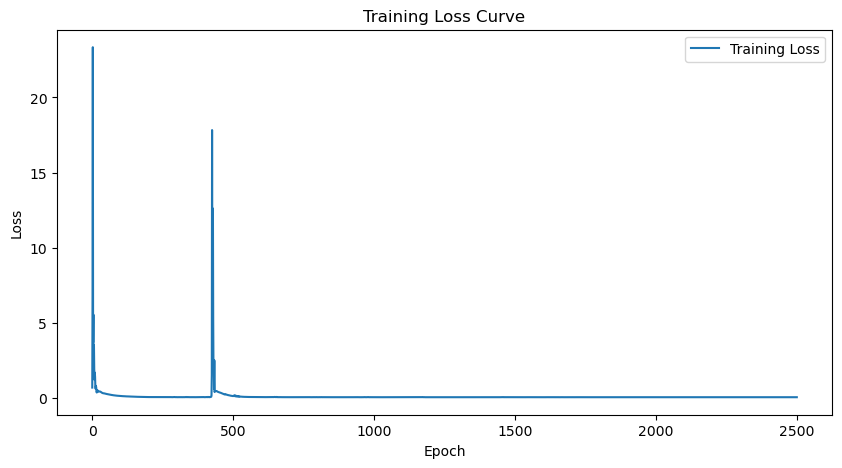

Best Model was saved at epoch 50 with F1-score 0.8017 and accuracy 80.49%


In [62]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [63]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 80.49%
                  precision    recall  f1-score   support

    infringement       0.80      0.82      0.81       123
non_infringement       0.82      0.79      0.80       123

        accuracy                           0.80       246
       macro avg       0.81      0.80      0.80       246
    weighted avg       0.81      0.80      0.80       246



/tmp/ipykernel_1342044/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 